Libraries imported successfully!

Dataset loaded successfully!

Dataset Head:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort

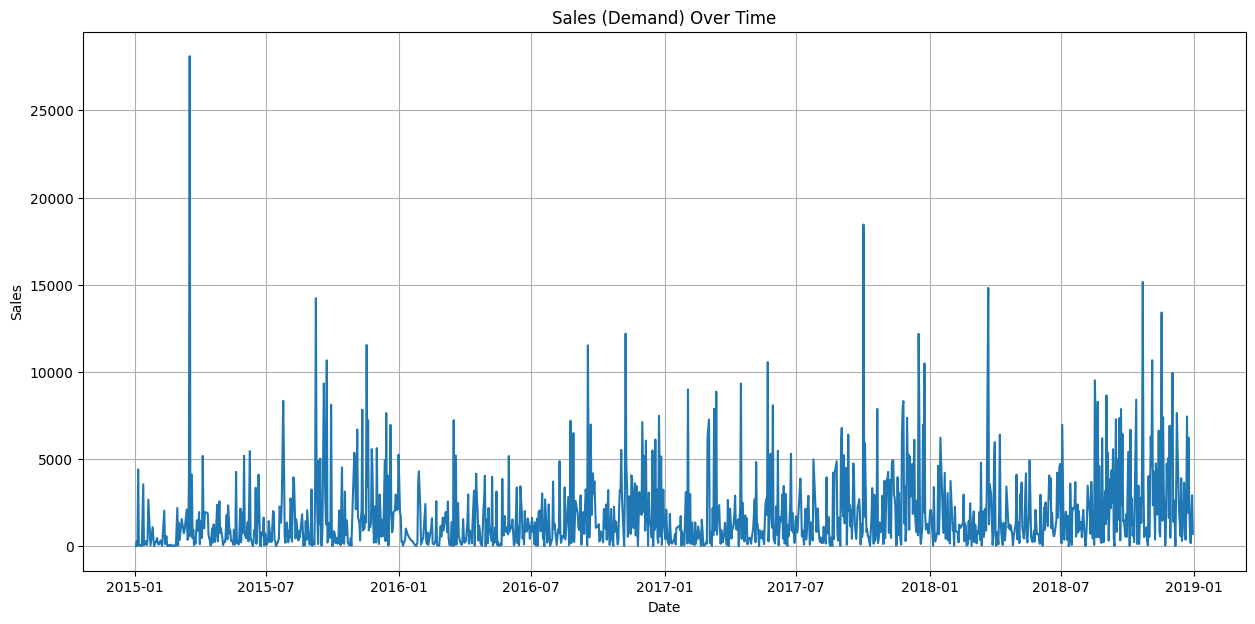

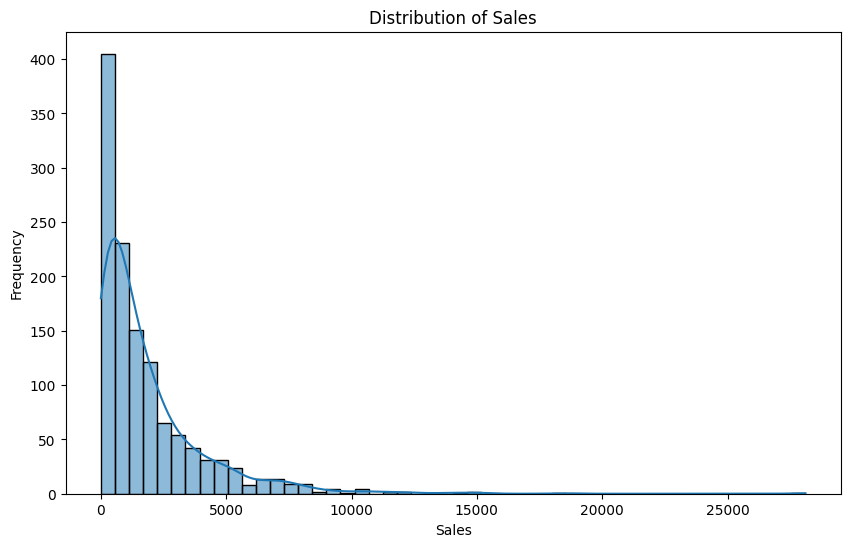


--- Feature Engineering ---
Shape before dropping NaNs from feature engineering: (1230, 18)
Shape after dropping NaNs from feature engineering: (1223, 18)

Features created successfully!
               Sales  year  month  day  dayofweek  dayofyear  weekofyear  \
Order Date                                                                 
2015-01-11     9.940  2015      1   11          6         11           2   
2015-01-13  3553.795  2015      1   13          1         13           3   
2015-01-14    61.960  2015      1   14          2         14           3   
2015-01-15   149.950  2015      1   15          3         15           3   
2015-01-16   299.964  2015      1   16          4         16           3   

            quarter  is_month_start  is_month_end  is_quarter_start  \
Order Date                                                            
2015-01-11        1               0             0                 0   
2015-01-13        1               0             0                 

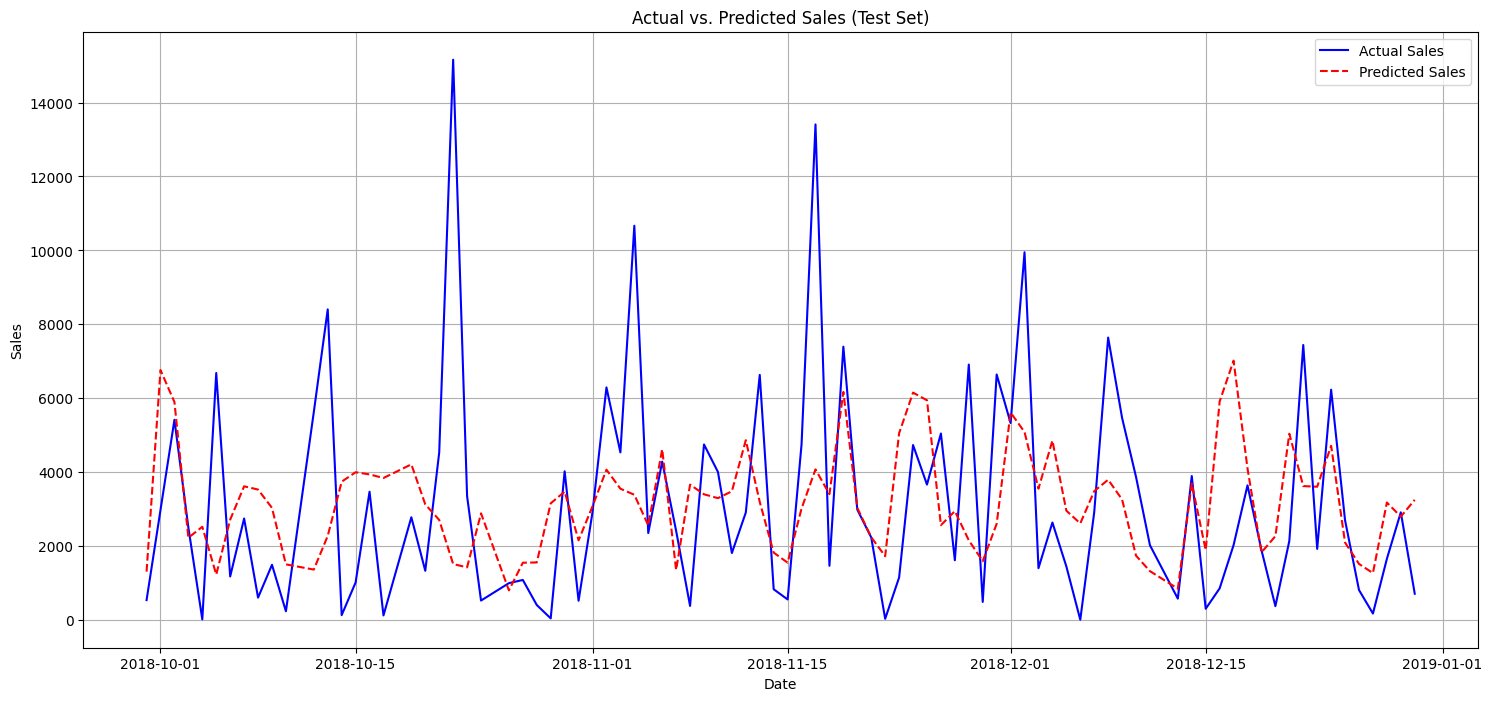

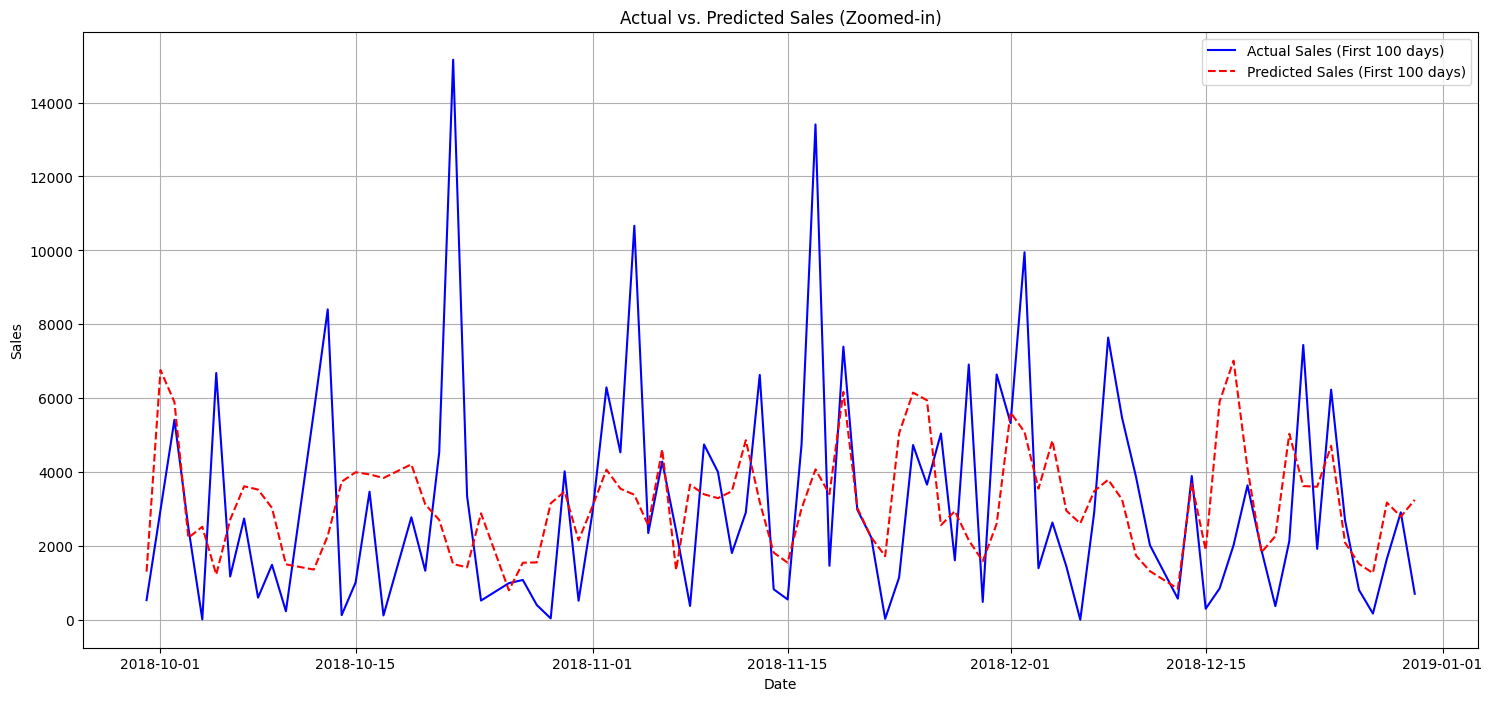


--- Saving the Trained Model ---
Model saved as 'xgboost_demand_model.joblib'
Features list saved as 'model_features.joblib'

Notebook execution complete. Model and features saved.


In [ ]:
# Short-Term Demand Forecasting for Manufacturing Plants - IPython Notebook

# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import joblib # To save/load the model

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# --- 2. Load & Preview Dataset ---
# Assuming 'train.csv' is in the same directory as this notebook
try:
    df = pd.read_csv('train.csv')
    print("\nDataset loaded successfully!")
    print("\nDataset Head:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nDataset Description:")
    print(df.describe())
except FileNotFoundError:
    print("Error: train.csv not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file isn't found

# --- 3. Data Cleaning ---
# Convert 'Order Date' column to datetime objects
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')


# Set 'Order Date' as index for time series operations
# Aggregate sales by 'Order Date' as there can be multiple orders on the same day
df = df.groupby('Order Date')['Sales'].sum().reset_index()
df = df.set_index('Order Date').sort_index()

# Check for missing values (after aggregation)
print("\nMissing values after aggregation:")
print(df.isnull().sum())

# For time series, often interpolation is used for missing values,
# but for this dataset, let's assume 'sales' is the target and fill
# any potential missing 'sales' with the previous valid observation (forward fill)
# or a mean/median if 'sales' is sparse.
# Let's check the nature of the data first. If 'sales' is the demand, it's likely
# already clean. Assuming 'sales' is the target variable based on context.

# Check for duplicates based on index (date) - should not be any after groupby
print("\nNumber of duplicate dates:", df.index.duplicated().sum())


print("\nData cleaning steps completed.")
print("Dataset info after cleaning:")
df.info()

# --- 4. Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis (EDA) ---")

# Plotting the time series of sales (demand)
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Sales'])
plt.title('Sales (Demand) Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Distribution of Sales
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Resample to weekly/monthly to see trends more clearly if daily data is noisy
# df_weekly = df['Sales'].resample('W').sum()
# df_monthly = df['Sales'].resample('M').sum()

# plt.figure(figsize=(15, 5))
# df_weekly.plot(title='Weekly Sales Sum')
# plt.show()

# plt.figure(figsize=(15, 5))
# df_monthly.plot(title='Monthly Sales Sum')
# plt.show()

# --- 5. Feature Engineering ---
print("\n--- Feature Engineering ---")

def create_features(df):
    """
    Creates time series features from the date index.
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['quarter'] = df.index.quarter
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)

    # Adding lag features (e.g., sales from previous day, 7 days ago)
    # Be careful not to create features that leak future information.
    # We will use shifts based on the target variable itself.
    df['sales_lag_1'] = df['Sales'].shift(1)
    df['sales_lag_7'] = df['Sales'].shift(7) # Weekly seasonality

    # Adding rolling window features (e.g., 7-day rolling mean)
    df['sales_rolling_mean_7'] = df['Sales'].rolling(window=7).mean().shift(1) # Shift to prevent data leakage
    df['sales_rolling_std_7'] = df['Sales'].rolling(window=7).std().shift(1)   # Shift to prevent data leakage

    return df.copy() # Return a copy to avoid SettingWithCopyWarning

df_features = create_features(df.copy()) # Pass a copy to avoid modifying original df

# Drop rows with NaN values created by lag and rolling features
print(f"Shape before dropping NaNs from feature engineering: {df_features.shape}")
df_features.dropna(inplace=True)
print(f"Shape after dropping NaNs from feature engineering: {df_features.shape}")

print("\nFeatures created successfully!")
print(df_features.head())

# --- 6. Train-Test Split ---
print("\n--- Train-Test Split ---")

# For time series, we split chronologically
# Let's use the last few months as the test set
# Determine the split point (e.g., 80% train, 20% test)
split_date = df_features.index.max() - pd.DateOffset(months=3) # Example: last 3 months for testing

train_df = df_features[df_features.index < split_date]
test_df = df_features[df_features.index >= split_date]

# Define features (X) and target (y)
features = [col for col in df_features.columns if col != 'Sales']
target = 'Sales'

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {len(features)}")

# --- 7. Modeling (XGBoost) ---
print("\n--- Modeling with XGBoost ---")

# Initialize XGBoost Regressor
# Parameters can be tuned further for better performance
model = xgb.XGBRegressor(
    objective='reg:squarederror', # For regression tasks
    n_estimators=1000,            # Number of boosting rounds
    learning_rate=0.05,           # Step size shrinkage
    max_depth=6,                  # Maximum depth of a tree
    subsample=0.7,                # Subsample ratio of the training instance
    colsample_bytree=0.7,         # Subsample ratio of columns when constructing each tree
    random_state=42,
    n_jobs=-1                     # Use all available cores
)

# Train the model
print("Training XGBoost model...")
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False) # Set to True for detailed training output

print("XGBoost model training completed.")


# --- 8. Evaluation ---
print("\n--- Model Evaluation ---")

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# --- 9. Visualization of Forecast ---
print("\n--- Visualization of Forecast ---")

# Create a DataFrame for actual vs. predicted values
forecast_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}, index=y_test.index)

plt.figure(figsize=(18, 8))
plt.plot(forecast_df['Actual'], label='Actual Sales', color='blue')
plt.plot(forecast_df['Predicted'], label='Predicted Sales', color='red', linestyle='--')
plt.title('Actual vs. Predicted Sales (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Plotting a zoom-in of the forecast for better detail
plt.figure(figsize=(18, 8))
plt.plot(forecast_df['Actual'].head(100), label='Actual Sales (First 100 days)', color='blue')
plt.plot(forecast_df['Predicted'].head(100), label='Predicted Sales (First 100 days)', color='red', linestyle='--')
plt.title('Actual vs. Predicted Sales (Zoomed-in)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


# --- 10. Build & Save the Trained Model ---
print("\n--- Saving the Trained Model ---")

# Save the trained XGBoost model
model_filename = 'xgboost_demand_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved as '{model_filename}'")

# It's also good practice to save the list of features used during training
# This is crucial for consistency when using the model for new predictions
features_filename = 'model_features.joblib'
joblib.dump(features, features_filename)
print(f"Features list saved as '{features_filename}'")

print("\nNotebook execution complete. Model and features saved.")